## Library & Data Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utility import (
    visualize_overall_ratings_summary,
    plot_overall_rating_correlation,
    plot_observer_vs_self_scatter,
    plot_observer_vs_user_scatter,
    plot_user_vs_self_scatter,
    get_low_rating_conversation_ids,
    plot_low_ratings_by_language,
    plot_low_rating_type_breakdown,
    plot_user_criteria_correlation,
    plot_user_criteria_distributions
)


In [3]:
overall_ratings_fp = './data/overall_ratings.csv'
per_turn_ratings_fp = './data/per_turn_ratings.csv'
criteria_ratings_user = './data/criteria_ratings/user.csv'
criteria_ratings_observer = './data/criteria_ratings/observer.csv'
criteria_ratings_self = './data/criteria_ratings/self.csv'

df_OR = pd.read_csv(overall_ratings_fp)
df_PTR = pd.read_csv(per_turn_ratings_fp)
df_CR_User= pd.read_csv(criteria_ratings_user)
df_CR_Observer = pd.read_csv(criteria_ratings_observer)
df_CR_Self = pd.read_csv(criteria_ratings_self)

# df_OR.drop(columns=['Convsation_Id'], inplace=True)
# df_PTR.drop(columns=['Conversation_ID'], inplace=True)
# df_CR_User.drop(columns=["Conversation_Id"], inplace=True)
# df_CR_Observer.drop(columns=["Conversation_Id"], inplace=True)
# df_CR_Self.drop(columns=["Conversation_Id"], inplace=True)

## Overall Ratings

In [19]:
# Overall ratings
df_OR_no_lang = df_OR.drop(columns=["Language"])
visualize_overall_ratings_summary(df_OR)

       Convsation_Id  User_Rating  Observer_Rating  Self_Rating
count     530.000000   530.000000       530.000000   530.000000
mean      265.322642     8.871698         8.589623     8.738679
std       153.395308     0.975383         0.920767     0.780259
min         0.000000     1.000000         1.000000     1.000000
25%       133.250000     9.000000         8.500000     9.000000
50%       265.500000     9.000000         9.000000     9.000000
75%       397.750000     9.000000         9.000000     9.000000
max       530.000000    10.000000         9.000000     9.000000


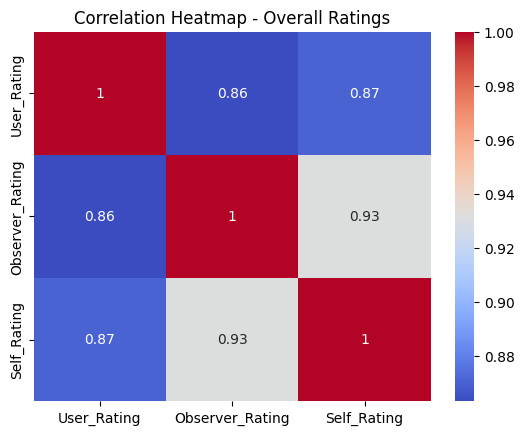

In [20]:
plot_overall_rating_correlation(df_OR)

In [21]:
df_OR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Convsation_Id    530 non-null    int64  
 1   User_Rating      530 non-null    float64
 2   Observer_Rating  530 non-null    float64
 3   Self_Rating      530 non-null    float64
 4   Language         529 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 20.8+ KB


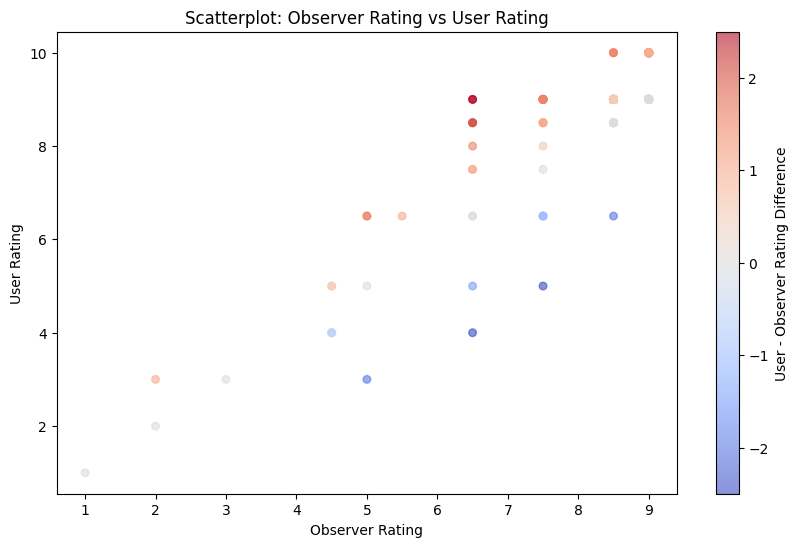

In [22]:


plot_observer_vs_user_scatter(df_OR)


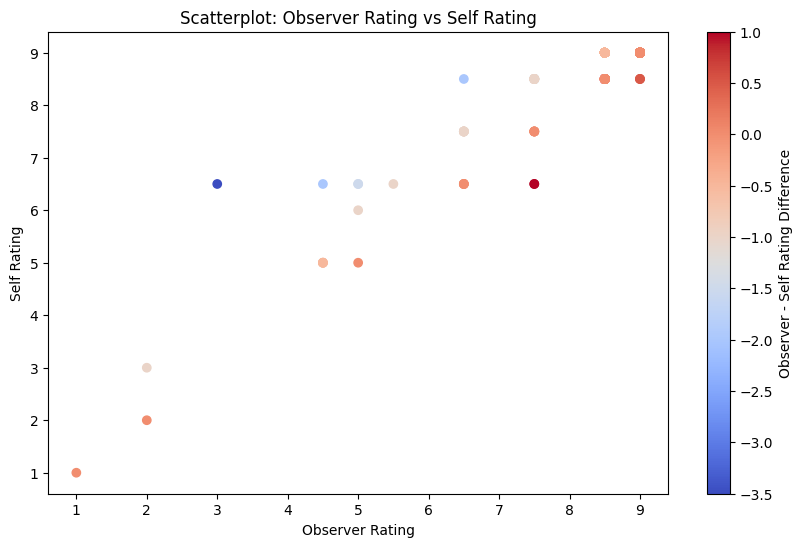

In [23]:
plot_observer_vs_self_scatter(df=df_OR)

In [24]:
print(df_OR['Observer_Self_Diff'].mean())


-0.1490566037735849


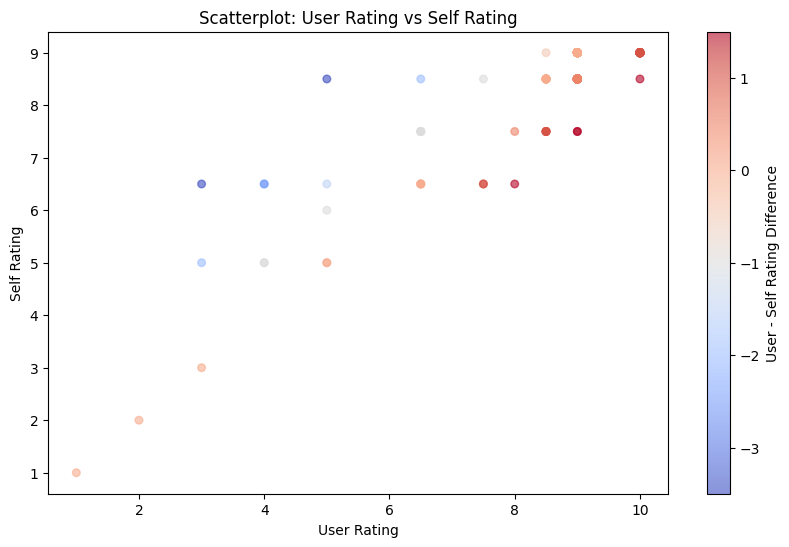

In [25]:
plot_user_vs_self_scatter(df=df_OR)

### Looking at lower ratings

In [26]:
# Looking 5th percentiles
user_thresh = df_OR['User_Rating'].quantile(0.0)
self_thresh = df_OR['Self_Rating'].quantile(0.05)
observer_thresh = df_OR['Observer_Rating'].quantile(0.05)

low_ratings_df = df_OR[
    (df_OR['User_Rating'] < user_thresh) |
    (df_OR['Self_Rating'] < self_thresh) |
    (df_OR['Observer_Rating'] < observer_thresh)
]

print(low_ratings_df.shape)
print(np.percentile(df_OR['User_Rating'], 4))
low_ratings_df.head()


(28, 8)
6.5


,Convsation_Id,User_Rating,Observer_Rating,Self_Rating,Language,User_Observer_Diff,Observer_Self_Diff,User_Self_Diff
22,22,4.0,6.5,6.5,English,-2.5,0.0,-2.5
23,23,5.0,5.0,6.0,English,0.0,-1.0,-1.0
26,26,3.0,5.0,5.0,English,-2.0,0.0,-2.0
27,27,5.0,6.5,6.5,English,-1.5,0.0,-1.5
37,37,6.5,5.0,6.5,Swahili,1.5,-1.5,0.0


In [27]:
# Get overall ratings that are less than the 5th percentil

def get_lower_overall_ratings():
    """Return rows where User, Self, or Observer ratings fall below the 5th percentile."""
    user_thresh = df_OR['User_Rating'].quantile(0.05)
    self_thresh = df_OR['Self_Rating'].quantile(0.05)
    observer_thresh = df_OR['Observer_Rating'].quantile(0.05)

    low_ratings_df = df_OR[
        (df_OR['User_Rating'] < user_thresh) |
        (df_OR['Self_Rating'] < self_thresh) |
        (df_OR['Observer_Rating'] < observer_thresh)
    ]['Convsation_Id'].tolist()
    return low_ratings_df



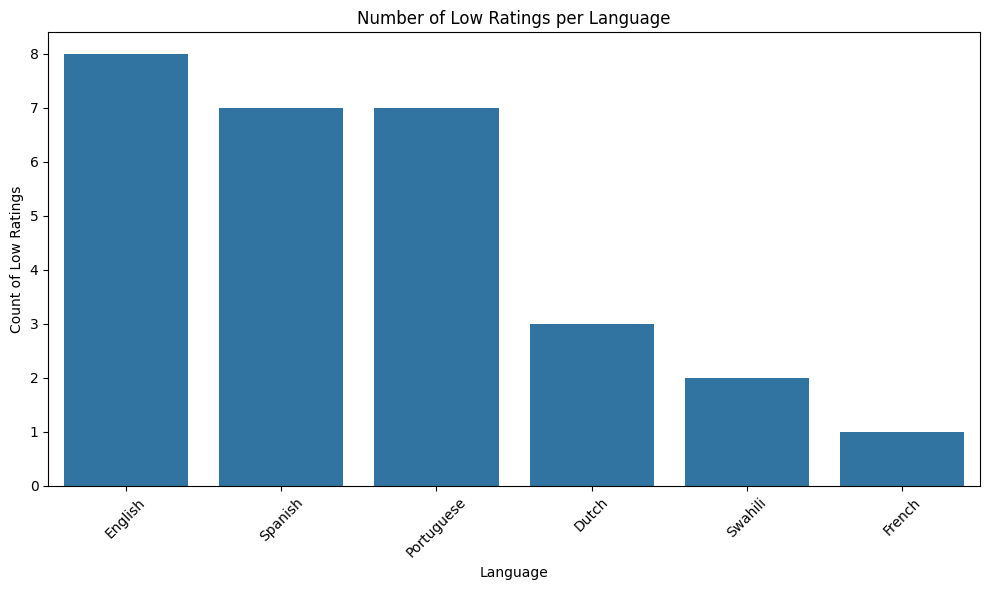

In [28]:
lang_counts = low_ratings_df['Language'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title('Number of Low Ratings per Language')
plt.xlabel('Language')
plt.ylabel('Count of Low Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3670092/1387140142.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_ratings_df['Low_Rating_Type'] = low_ratings_df.apply(get_low_rating_type, axis=1)


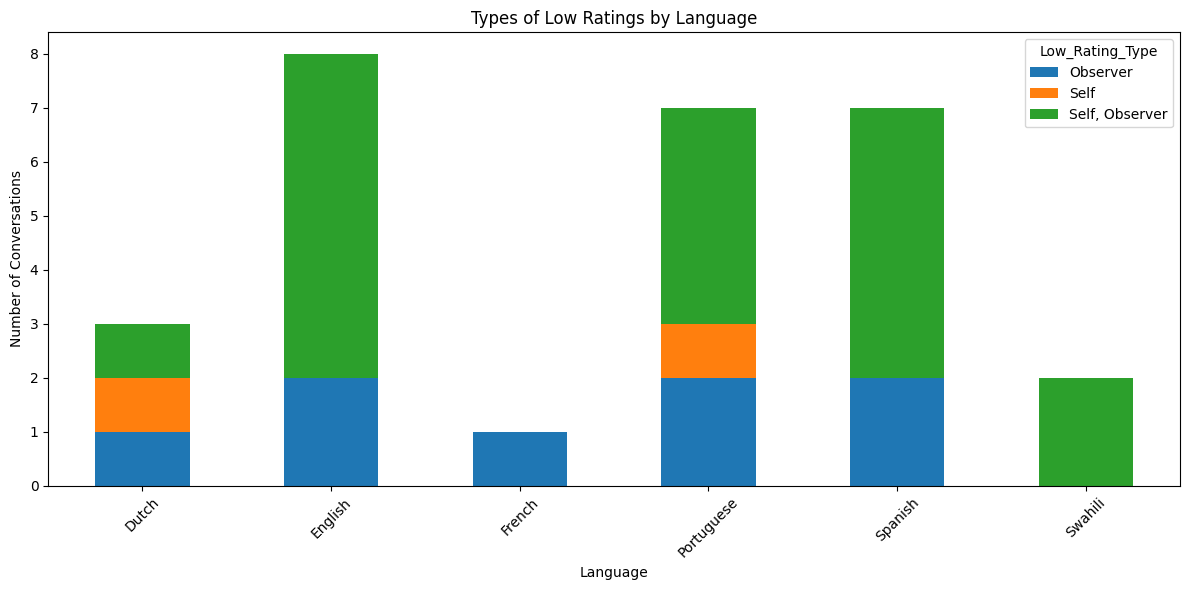

In [29]:
def get_low_rating_type(row):
    types = []
    if row['User_Rating'] < user_thresh:
        types.append('User')
    if row['Self_Rating'] < self_thresh:
        types.append('Self')
    if row['Observer_Rating'] < observer_thresh:
        types.append('Observer')
    return ', '.join(types)

low_ratings_df['Low_Rating_Type'] = low_ratings_df.apply(get_low_rating_type, axis=1)

breakdown = low_ratings_df.groupby(['Language', 'Low_Rating_Type']).size().unstack(fill_value=0)

breakdown.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Types of Low Ratings by Language')
plt.ylabel('Number of Conversations')
plt.xlabel('Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Cross Language Analysis

In [30]:
languages = df_OR['Language'].unique()
languages

array(['English', 'Spanish', 'French', 'Dutch', 'Portuguese', 'Swahili',
       'Haitian Creole', nan, 'Zulu', 'Hindi', 'Nederlands', 'Español'],
      dtype=object)

In [31]:
language_dfs = {lang: df_OR[df_OR['Language'] == lang] for lang in languages}

##### English

In [32]:
df_OR_english = language_dfs['English']
df_OR_english.shape

(197, 8)

#### Spanish

In [33]:
df_OR_english = language_dfs['Spanish']
df_OR_english.shape


(52, 8)

## Per Turn Ratings

In [4]:
# Per turn ratings
df_PTR = df_PTR.apply(pd.to_numeric, errors='coerce')
df_PTR.describe()

,Conversation_ID,Turn_1,Turn_2,Turn_3,Turn_4,Turn_5,Turn_6,Turn_7,Turn_8,Turn_9,...,Turn_16,Turn_17,Turn_18,Turn_19,Turn_20,Turn_21,Turn_22,Turn_23,Turn_24,Turn_25
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,...,526.000000,526.000000,525.000000,524.000000,523.000000,520.000000,518.000000,516.000000,516.000000,514.000000
mean,265.322642,8.474528,8.476415,8.480189,8.517925,8.529245,8.500943,8.500000,8.503774,8.454717,...,8.347909,8.364068,8.395238,8.369275,8.402486,8.304808,8.321429,8.289729,8.281977,8.193580
std,153.395308,1.017248,0.890992,1.017839,0.901668,0.937858,0.984040,1.003303,0.990973,1.058687,...,1.257990,1.268318,1.190963,1.084653,1.138853,1.342529,1.284284,1.299690,1.371855,1.514381
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,133.250000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,...,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000
50%,265.500000,8.500000,8.500000,8.500000,9.000000,9.000000,9.000000,9.000000,8.500000,8.500000,...,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000
75%,397.750000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
max,530.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.500000,9.000000,9.000000,9.000000


## Criteria Ratings

### User Ratings

In [54]:
# Critera - User
df_CR_User.describe()

,Conversation_Id,Clarity_and_Simplicity,Relevance_and_Accuracy,Tone_and_Supportiveness,Adaptability,Consistency_and_Flow
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,265.322642,8.890566,8.934906,8.913208,8.683962,8.714151
std,153.395308,0.601908,0.660103,0.551690,0.992708,0.932448
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,133.250000,9.000000,9.000000,9.000000,9.000000,9.000000
50%,265.500000,9.000000,9.000000,9.000000,9.000000,9.000000
75%,397.750000,9.000000,9.000000,9.000000,9.000000,9.000000
max,530.000000,9.000000,10.000000,9.500000,9.000000,9.000000


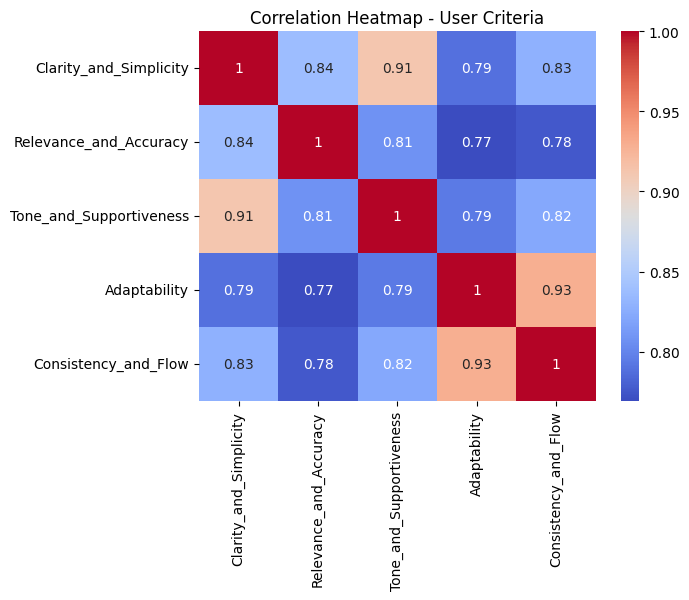

In [39]:
# df_CR_User_No_Lang = df_CR_User.drop(columns=["Language"])
plot_user_criteria_correlation(df_CR_User)


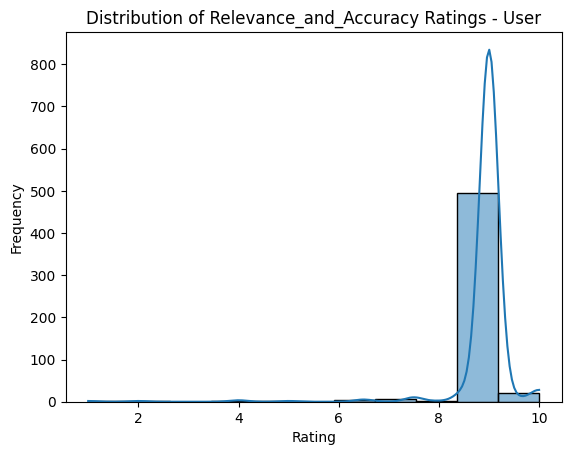

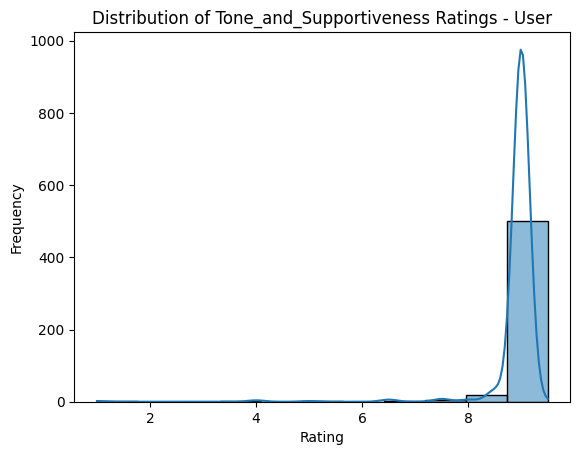

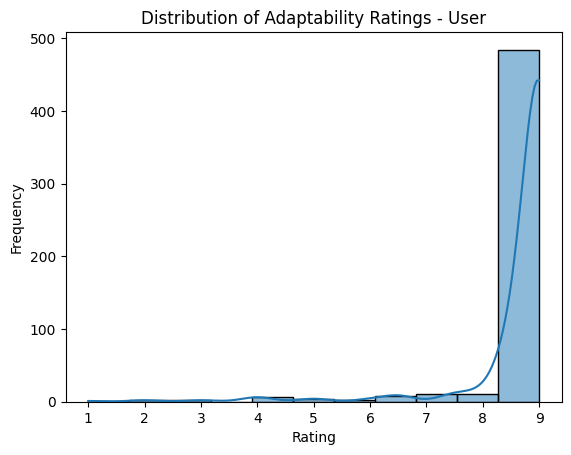

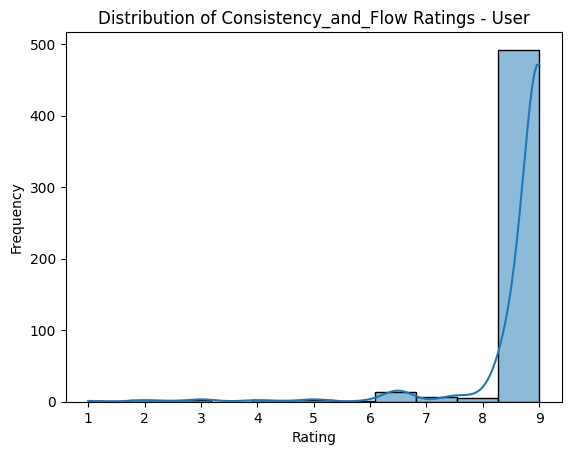

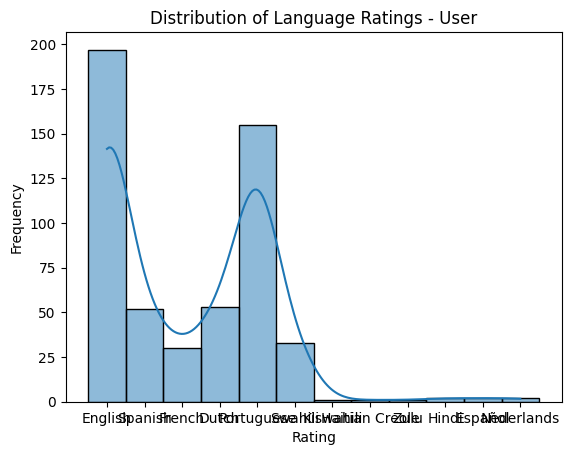

In [41]:
# Distribution over different criteria
plot_user_criteria_distributions(df_CR_User)


In [ ]:
print(np.percentile(df_CR_User['Clarity_and_Simplicity'], 4))


8.08


### Observer Ratings

In [17]:
# Criteria - Observer
df_CR_Observer.describe()

,Clarity_and_Simplicity,Relevance_and_Accuracy,Tone_and_Supportiveness,Adaptability,Consistency_and_Flow
count,530.000000,530.000000,530.000000,530.000000,530.000000
mean,8.810377,9.141509,8.833019,8.466038,8.443396
std,0.721913,1.051497,0.690842,1.108388,1.134026
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,9.000000,9.000000,9.000000,8.500000,8.500000
50%,9.000000,9.000000,9.000000,9.000000,9.000000
75%,9.000000,10.000000,9.000000,9.000000,9.000000
max,9.000000,10.000000,9.000000,9.000000,10.000000


In [18]:
print(np.percentile(df_CR_Observer['Tone_and_Supportiveness'], 50))

9.0


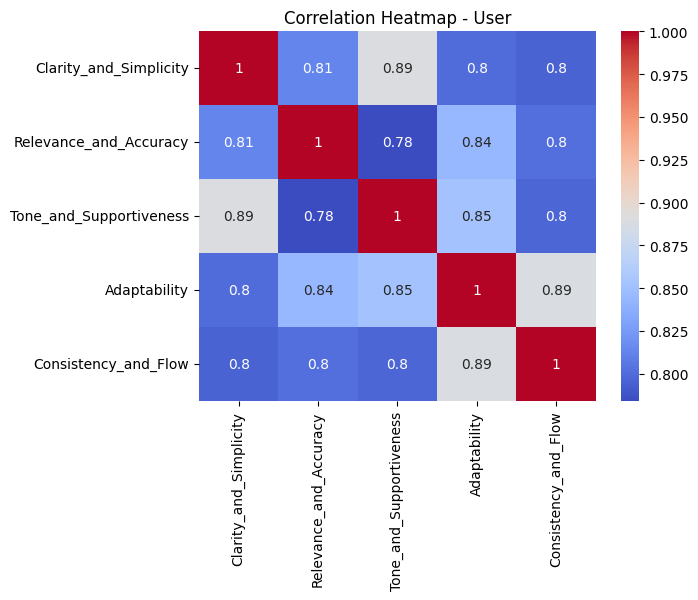

In [19]:
df_CR_Observer_No_Lang = df_CR_Observer.drop(columns=["Language"])
CR_Observer_corr_matrix = df_CR_Observer_No_Lang.corr()
sns.heatmap(CR_Observer_corr_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap - User')
plt.show()

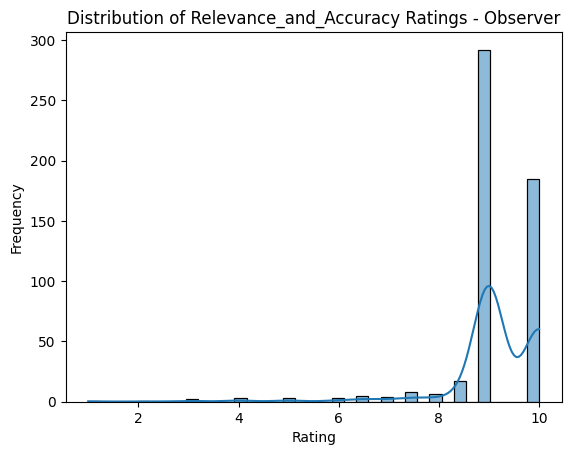

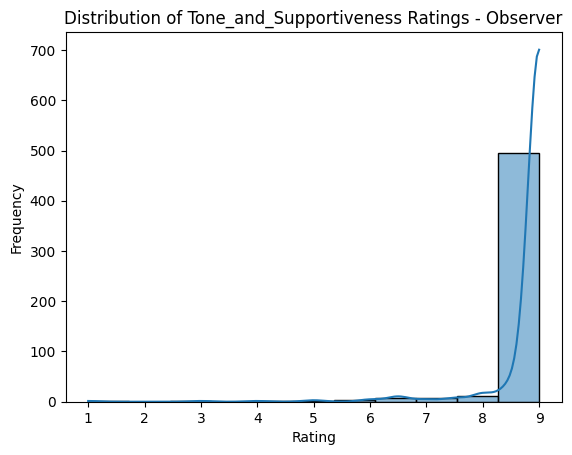

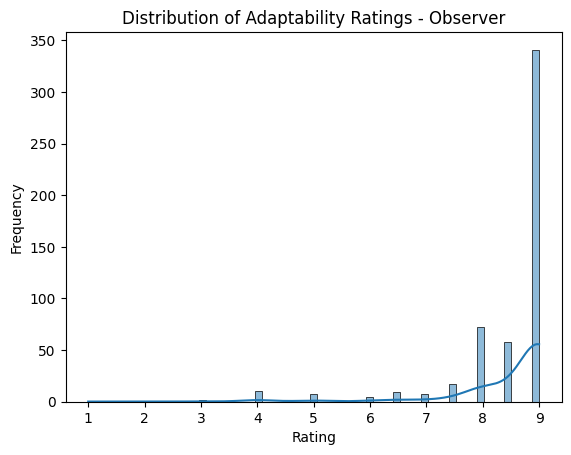

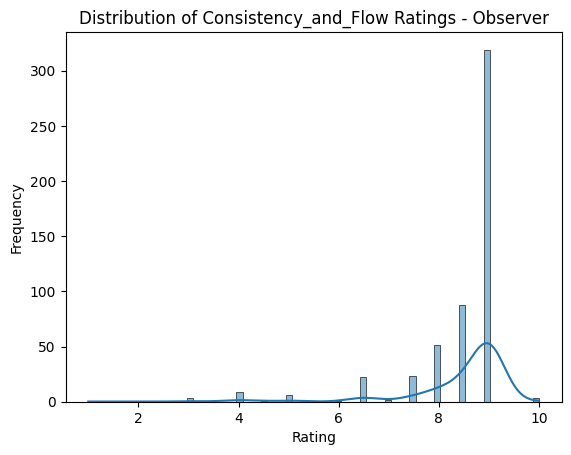

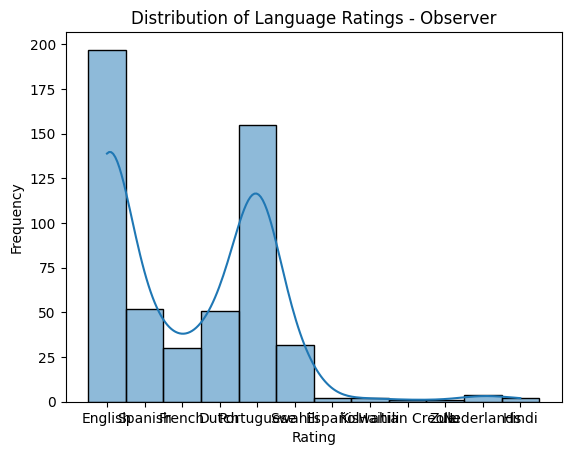

In [20]:
for column in df_CR_Observer.columns[1:]:
    sns.histplot(df_CR_Observer[column], kde=True)
    plt.title(f'Distribution of {column} Ratings - Observer')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

### Self Ratings

In [21]:
# Criteria - Self
df_CR_Self.head()

,Clarity_and_Simplicity,Relevance_and_Accuracy,Tone_and_Supportiveness,Adaptability,Consistency_and_Flow,Language
0,9.0,9.0,9.0,8.0,9.0,English
1,8.5,9.0,9.0,9.0,8.5,English
2,9.0,9.0,9.0,8.0,9.0,English
3,8.5,9.0,9.0,8.5,8.5,English
4,9.0,9.0,9.0,9.0,9.0,English


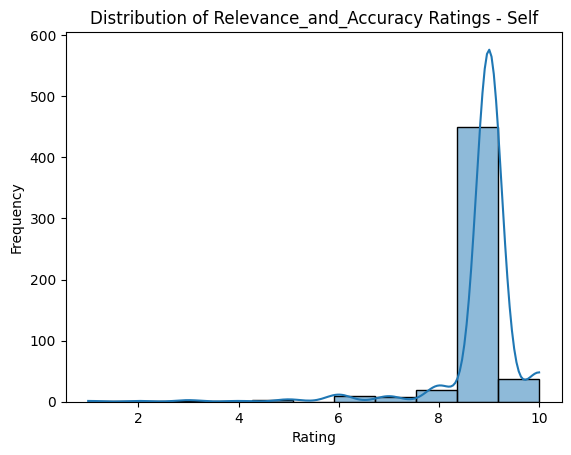

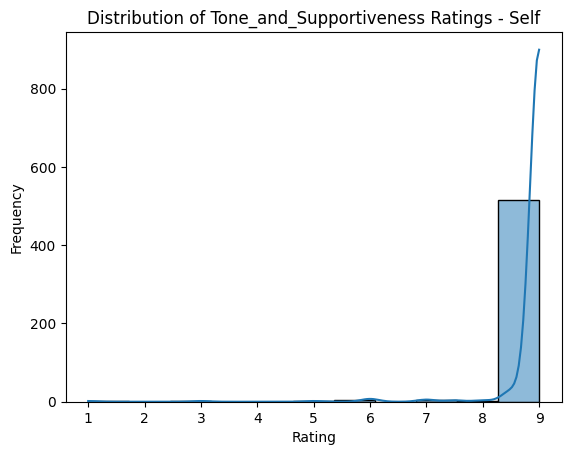

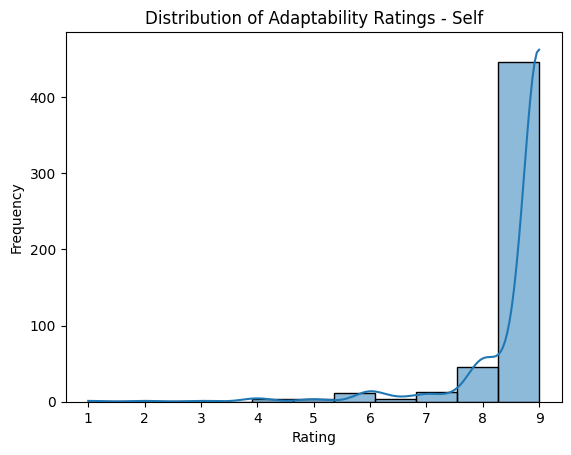

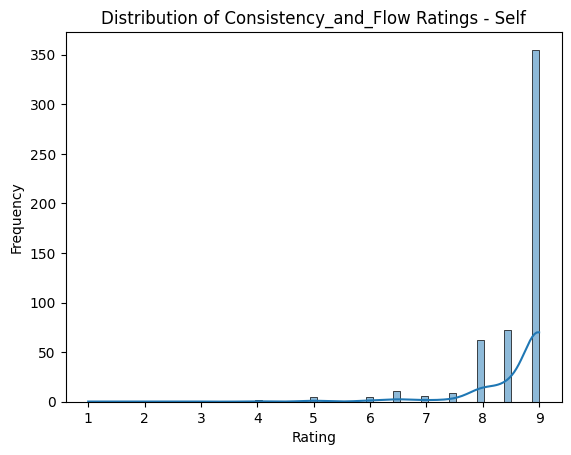

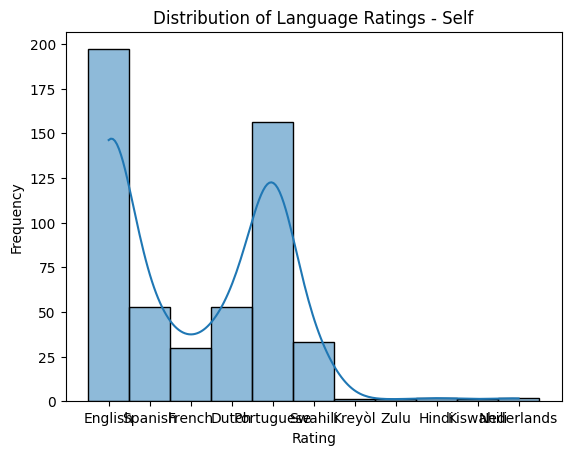

In [22]:
for column in df_CR_Self.columns[1:]:
    sns.histplot(df_CR_Self[column], kde=True)
    plt.title(f'Distribution of {column} Ratings - Self')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()
